
## 모듈 임포트 및 데이터 로드


 #### 구글 드라이브와 Colab을 연동합니다



In [0]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os


if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import shutil
         


def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/딥러닝/kobert/002_bert_morp_tensorflow", "bert")

In [0]:
os.listdir('bert')

['vocab.korean_morp.list',
 'src_tokenizer',
 'bert_model.ckpt.index',
 'bert_config.json',
 'bert_model.ckpt.meta',
 'KorBERT_FAQ_20190619.pdf',
 'bert_model.ckpt.data-00000-of-00001']

- Colab에서 Bert 모형을 가지고 있는 폴더를 지정해줍니다  

- 파이썬 명령어 os.listdir(path)를 활용하여 폴더가 잘 있는지 확인하면서 진행합니다.

In [0]:
path = "/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/딥러닝"

텐서플로우, 판다스, 넘파이, 케라스 등 필요한 모듈들을 임포트합니다

In [0]:
%tensorflow_version 1.x
import os
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

케라스에서 Bert 활용을 쉽게 만들어주는 모듈 keras-bert를 설치합니다<br>그리고 Adam optimizer의 수정판인 keras-radam 모듈을 임포트합니다.

In [0]:
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=a48c19dcf51506ca94631f8f28db10ec16b4ba14d89b8198802b08e2f56f799d
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=b20b3f729bde9119d99c87fa1d6281080149a5ac65d6e8f18ba22f71f1554952
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=5fce532f325840f0a67e982fab543cc2ffdc3d1e68d34c1696092ad0e4488490
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=9253d913342c425de5702bb177a3d0f9ac2697a5bc8300b38c3e968647b0d2ae
  Stor

keras-bert 라이브러리에서 버트 모형 활용에 필요한 모듈들을 임포트합니다

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [0]:
os.listdir('bert')

['vocab.korean_morp.list',
 'src_tokenizer',
 'bert_model.ckpt.index',
 'bert_config.json',
 'bert_model.ckpt.meta',
 'KorBERT_FAQ_20190619.pdf',
 'bert_model.ckpt.data-00000-of-00001']

데이터 로드

In [0]:
df = pd.read_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/딥러닝/glowpick_end.csv')

In [0]:
df['rating'].unique()

array([4, 3, 5, 2, 1])

In [0]:
#to_categorical 함수는 max값으로 카테고리 몇개있는지 인식하고 0부터 인식하기 때문에, 1~5있으면 6개 category있는 걸로 오해함.
df['label'] = df['rating']-1

In [0]:
for i in range(len(df['label'])):
  if df['label'][i] in [0,1,2]:
    df['label'][i] = 0
  else:
    df['label'][i] = 1 

In [0]:
df

product  ... label
0      소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1
1      소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1
2      소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1
3      소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1
4      소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1
...                               ...  ...   ...
53585                      리얼핏 매트 립스틱  ...     1
53586                      리얼핏 매트 립스틱  ...     0
53587                      리얼핏 매트 립스틱  ...     1
53588                      리얼핏 매트 립스틱  ...     1
53589                      리얼핏 매트 립스틱  ...     1

[53590 rows x 13 columns]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
#stratified
y = df['label']
X = df.drop(['label','rating'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=99, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=99, shuffle=True, stratify=y_train)

In [0]:
train = pd.concat([X_train, y_train], axis=1).reset_index()
test = pd.concat([X_val, y_val], axis=1).reset_index()

## 모델 사전 설정 및 단계별 형태소 분석


- bert 훈련을 위한 사전 설정을 합니다. SEQ_LEN은 문장의 최대 길이입니다. SEQ_LEN 보다 문장의 길이가 작다면 남은 부분은 0이 채워지고, 만약에 SEQ_LEN보다 문장 길이가 길다면 SEQ_LEN을 초과하는 부분이 잘리게 됩니다.  
- BATCH_SIZE는 메모리 초과 같은 문제를 방지하기 위해 작은 수인 16으로 정했습니다. 그리고 총 훈련 에포크 수는 2로 정했습니다. 학습율(LR;Learning rate)은 1e-5로 작게 정했습니다.  
- pretrained_path는 bert 사전학습 모형이 있는 폴더를 의미합니다.
- 그리고 우리가 분석할 문장이 들어있는 칼럼의 제목인 document와 긍정인지 부정인지 알려주는 칼럼을 label로 정해줍니다


In [0]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
#vocab_path = os.path.join(pretrained_path, 'vocab.korean_morp.list')

DATA_COLUMN = "fin_review"
LABEL_COLUMN = "label"

In [0]:
# LIBRARIES

import collections       # OrderedDict를 위해 호출
import re                # 정규표현식
import unicodedata       # 한국어 정준분해 및 문자열 확인
import six               # Python version 체크
import tensorflow as tf  # Tensorflow 파일 불러오기 및 logging

In [0]:
# ARGUMENTS

# ETRI에서 받은 file path를 저장
path2 = '/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/딥러닝/kobert/002_bert_morp_tensorflow/'
path4 = '/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/딥러닝/kobert/004_bert_eojeol_tensorflow/'
# 한국어 vocab 사전을 등록
morph_vocab_file = path2 + 'vocab.korean_morp.list'
rawtext_vocab_file = path4 + 'vocab.korean.rawtext.list'

do_lower_case = True # default=False, 정준분해 예시를 위해 True로 설정
max_len = None # 없으면 1e12

형태소 분석 라이브러리 임포트

In [0]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git



Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 60 (delta 23), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [0]:
!cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh


bash: install_mecab-ko_on_colab190912.sh: No such file or directory


In [0]:
!git clone https://github.com/kakao/khaiii.git

!pip install cmake

!mkdir build

!cd build && cmake /content/khaiii

!cd /content/build/ && make all

!cd /content/build/ && make resource

!cd /content/build && make install

!cd /content/build && make package_python

!pip install /content/build/package_python

from khaiii import KhaiiiApi
api = KhaiiiApi()
for word in api.analyze("안녕, 세상."):
    print(word)


Cloning into 'khaiii'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 957 (delta 25), reused 49 (delta 19), pack-reused 877
Receiving objects: 100% (957/957), 33.03 MiB | 32.56 MiB/s, done.
Resolving deltas: 100% (383/383), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-

In [0]:
#khaii 분석기 
def Analyze(self, text, SEP=' + '):
   
    res = self.analyze(text)
    f = lambda x: x.__str__().split('\t')[1]
    return SEP.join(list(map(f, res)))

khai3 = KhaiiiApi()
setattr(khai3.__class__, 'Analyze', Analyze)

In [0]:
# 단어 사전 호출

def convert_to_unicode(text):
    # Python version이 3.x일 때,
    # type(text)이 `bytes`일 경우, utf-8로 변환
    if six.PY3:
        if isinstance(text, str):
            return text
        elif isinstance(text, bytes):
            return text.decode("utf-8", "ignore")
        else:
            raise ValueError("Unsupported string type: %s" % (type(text)))
    # Python version이 2.x일 때,
    # type(text)이 `str`일 경우, utf-8로 변환
    elif six.PY2:
        if isinstance(text, str):
            return text.decode("utf-8", "ignore")
        elif isinstance(text, unicode):
            return text
        else:
            raise ValueError("Unsupported string type: %s" % (type(text)))
    # Python 3.x, 2.x만 허용!
    else:
        raise ValueError("Not running on Python2 or Python 3?")
        
        
def _load_vocab(vocab_file):
    # 단어 사전을 저장할 OrderedDict 객체 생성
    vocab = collections.OrderedDict()
    index = 0
    with tf.io.gfile.GFile(vocab_file, 'r') as reader:
        while True:
            # Binary Text를 unicode(utf-8)로 decode.
            token = convert_to_unicode(reader.readline())
            if not token: break
            if ((token.find('n_iters=') == 0) or
                (token.find('max_length=') == 0)):
                continue
            token = token.split('\t')[0]
            token = token.strip()
            # 토큰과 해당 index를 기록
            vocab[token] = index
            index += 1
    return vocab

# 단어 사전 호출
morph_vocab = _load_vocab(morph_vocab_file)
rawtext_vocab = _load_vocab(rawtext_vocab_file)

In [0]:
# 100개만 출력해보기
# 뒤의 품사에 `_`가 붙은 것을 잘 기억해두기
{key:value for i, (key, value) in enumerate(morph_vocab.items()) if i < 100}

{'"/SS_': 25,
 '%/SW_': 81,
 "'/SS_": 26,
 '(/SS_': 29,
 ')/SS_': 30,
 ',/SP_': 17,
 '-/SS_': 95,
 './SF_': 7,
 '/NNG_': 83,
 '1/SN_': 50,
 '2/SN_': 54,
 '3/SN_': 63,
 '4/SN_': 82,
 '5/SN_': 91,
 '<S>': 5,
 '<T>': 6,
 '[CLS]': 2,
 '[MASK]': 4,
 '[PAD]': 0,
 '[SEP]': 3,
 '[UNK]': 1,
 '·/SP_': 75,
 '‘/SS_': 65,
 '’/SS_': 66,
 '“/SS_': 67,
 '”/SS_': 69,
 'ㄴ/ETM_': 10,
 'ㄴ다/EF_': 41,
 'ㄹ/ETM_': 35,
 '가/JKS_': 24,
 '것/NNB_': 33,
 '게/EC_': 47,
 '고/EC_': 23,
 '고/JKQ_': 64,
 '과/JC_': 46,
 '과/JKB_': 84,
 '그/NP_': 90,
 '기/ETN_': 49,
 '까지/JX_': 79,
 '년/NNB_': 39,
 '는/ETM_': 22,
 '는/JX_': 18,
 '다/EF_': 8,
 '다고/EC_': 96,
 '다는/ETM_': 89,
 '대하/VV_': 73,
 '던/ETM_': 68,
 '도/JX_': 34,
 '되/VV_': 57,
 '되/XSV_': 32,
 '들/XSN_': 36,
 '등/NNB_': 51,
 '로/JKB_': 31,
 '를/JKO_': 19,
 '만/JX_': 98,
 '만/NR_': 85,
 '말/NNG_': 72,
 '며/EC_': 53,
 '면/EC_': 71,
 '면서/EC_': 88,
 '명/NNB_': 87,
 '받/VV_': 78,
 '수/NNB_': 55,
 '아/EC_': 62,
 '않/VX_': 59,
 '았/EP_': 43,
 '어/EC_': 20,
 '어서/EC_': 94,
 '없/VA_': 70,
 '었/EP_': 12,
 '에/JK

In [0]:
# 100개만 출력해보기
# 뒤의 품사에 `_`가 붙은 것을 잘 기억해두기
{key:value for i, (key, value) in enumerate(rawtext_vocab.items()) if i < 100}

{'"': 14,
 "'": 17,
 '(': 15,
 ')': 19,
 ')_': 66,
 ',_': 8,
 '.': 42,
 '._': 7,
 '1': 52,
 '2': 65,
 '3': 71,
 '4': 99,
 '5': 98,
 '<S>': 5,
 '<T>': 6,
 '[CLS]': 2,
 '[MASK]': 4,
 '[PAD]': 0,
 '[SEP]': 3,
 '[UNK]': 1,
 '_': 9,
 '‘': 84,
 '“': 88,
 '가': 41,
 '가_': 25,
 '고': 39,
 '고_': 23,
 '공': 89,
 '과_': 30,
 '구': 93,
 '기': 37,
 '나': 85,
 '는_': 21,
 '다': 33,
 '대': 38,
 '도': 81,
 '도_': 29,
 '동': 75,
 '라': 94,
 '로': 77,
 '로_': 26,
 '를_': 32,
 '리': 47,
 '마': 72,
 '무': 69,
 '미': 87,
 '보': 60,
 '부': 55,
 '비': 73,
 '사': 35,
 '상': 64,
 '성': 80,
 '세': 83,
 '소': 79,
 '수': 40,
 '수_': 43,
 '스': 56,
 '시': 36,
 '신': 67,
 '아': 53,
 '어': 62,
 '에_': 13,
 '에서_': 22,
 '여': 97,
 '연': 91,
 '오': 86,
 '와_': 54,
 '원': 68,
 '유': 61,
 '으로_': 31,
 '은_': 18,
 '을_': 12,
 '의_': 11,
 '이': 20,
 '이_': 10,
 '이다': 63,
 '인': 51,
 '인_': 57,
 '일': 46,
 '있는_': 92,
 '있다': 28,
 '자': 48,
 '장': 70,
 '재': 95,
 '전': 44,
 '정': 49,
 '제': 76,
 '조': 74,
 '주': 45,
 '지': 27,
 '지_': 82,
 '하': 90,
 '하고_': 58,
 '하는_': 34,
 '한': 96,
 '한_

In [0]:
#토큰화 코드
def tokenize(self, text):
      split_tokens = []
      # End to End Tokenizing.
      for token in self.basic_tokenizer.tokenize(text):
          # ETRI Vocab 양식에 맞게 token 끝에 '_'를 붙여준다.
          token += '_'
          for sub_token in self.wordpiece_tokenizer.tokenize(token):
              split_tokens.append(sub_token)
      return split_tokens

In [0]:
SPLIT_TOKENS = [] # 최종적으로 return할 list 생성

In [0]:
def tokenize(self, text):
      text = convert_to_unicode(text) #1
      text = self._clean_text(text)   #2

      orig_tokens = whitespace_tokenize(text) #3
      split_tokens = []
      for token in orig_tokens:
          if self.do_lower_case:
              # 현재 input으로 '고객/NNG'와 같이 Part-of-speech가 이미
              # tagging되어있고 vocab은 '고객/NNG_'로 단어를 기록하고 있음.
              # 여기서 `lower` 메서드를 사용하면 뒤의 tagging이 소문자로
              # 변환되어 값의 비교를 못하게 되므로 이를 주석처리.

              # token.lower()

              # 모든 음절을 정준 분해시키는 함수
              token = self._run_strip_accents(token) #4
          split_tokens.extend(self._run_split_on_punc(token)) #5
      output_tokens = whitespace_tokenize(" ".join(split_tokens)) #6
      return output_tokens


전처리

In [0]:
#1. unicode 변환

text = convert_to_unicode(khai3.Analyze(df[DATA_COLUMN][2]))
text

'백/NR + 탁/MAG + 현상/NNG + 없/VA + 고/EC + 부드럽/VA + 게/EC + 발리/VV + 어/EC + 지/VX + 어서/EC + 아주/MAG + 맘/NNG + 들/VV + 어요/EC'

In [0]:
## Tokenize하면서 계속 사용된 character 단위 함수 정의
def _is_control(char):
    if char == "\t" or char == "\n" or char == "\r":
        # 개행문자이면 False 반환
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        # unicode category가
        # Cc(Control)
        # Cf(format)
        # Co(Private Use, is 0)
        # Cs(Surrrogate, is 0)일 경우, True 반환
        # https://en.wikipedia.org/wiki/Control_character
        return True
    # 이 외의 경우 전부 False 반환
    return False
    
def _is_whitespace(char):
    if char == " " or char == '\t' or char == '\n' or char == '\r':
        # 개행문자이거나 띄어쓰기면 True 반환
        return True
    cat = unicodedata.category(char)
    if cat == 'Zs':
        # unicode category가 Space Seperator면 True 반환
        # https://www.compart.com/en/unicode/category/Zs
        return True
    # 이 외의 경우 전부 False 반환
    return False

def _is_punctuation(char):
    # 한국어 형태소 분석기이기 때문에 공백과 같은지 여부만 반환
    return char == ' '

In [0]:
#2. text cleaning
def _clean_text(text):
    output = [] # char을 저장할 list 생성
    for char in text:
        # 텍스트에서 Char 단위로 출력
        cp = ord(char)
        if cp == 0 or cp == 0xfffd or _is_control(char):
            # \x00이거나 �이거나 unicode cat.이 C로 시작할 경우
            # (개행문자 제외) output에 추가하지 않는다.
            continue
        if _is_whitespace(char):
            # 공백일 경우 " "으로 output에 추가
            output.append(" ")
        else:
            # 이 외의 경우 전부 output에 추가
            output.append(char)
    # cleaning 작업을 거친 Text를 후처리하여 반환
    return "".join(output)

_clean_text(text) 

'백/NR + 탁/MAG + 현상/NNG + 없/VA + 고/EC + 부드럽/VA + 게/EC + 발리/VV + 어/EC + 지/VX + 어서/EC + 아주/MAG + 맘/NNG + 들/VV + 어요/EC'

토큰화

버트 모형은 문장 앞에 꼭 [CLS]라는 문자가 위치하고, [SEP]라는 문자가 끝에 위치합니다.  
[CLS]는 문장의 시작, [SEP]는 문장의 끝을 의미합니다.

In [0]:
#3. whitespacing(띄어쓰기로 token화)
# text 단위 공백 처리
def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip() # 양 사이드의 공백을 제거
    if not text: # 어떠한 값도 없을 시, 빈 list를 반환
        return []
    tokens = text.split() # 공백 단위로 쪼갠 list를 반환
    return tokens

orig_tokens = whitespace_tokenize(text)
orig_tokens

['백/NR',
 '+',
 '탁/MAG',
 '+',
 '현상/NNG',
 '+',
 '없/VA',
 '+',
 '고/EC',
 '+',
 '부드럽/VA',
 '+',
 '게/EC',
 '+',
 '발리/VV',
 '+',
 '어/EC',
 '+',
 '지/VX',
 '+',
 '어서/EC',
 '+',
 '아주/MAG',
 '+',
 '맘/NNG',
 '+',
 '들/VV',
 '+',
 '어요/EC']

In [0]:
split_tokens = []
# >>> 첫 번째 for loop
token = orig_tokens[0]
token # for loop 돌리기 전에 어떻게 돌아가는지 체크
# token = '심사 숙고'

'백/NR'

In [0]:
#4. 음절을 정준분해
#print(token, end=' >> ')
token = unicodedata.normalize("NFD", token)
print(list(token))
print('print(token) ==', token, '(사실 출력시에는 변화 X)')
# https://gist.github.com/Pusnow/aa865fa21f9557fa58d691a8b79f8a6d
# 모든 음절을 정준 분해(Canonical Decomposition)시킴
# '각'을 'ㄱ+ㅏ+ㄱ'으로 저장(출력되는 값은 동일)
output = []
for char in token:
    cat = unicodedata.category(char)
    if cat == "Mn":
        # unicode category가 "Mark, Nonspacing"일 경우 pass
        continue
    output.append(char)
token = ''.join(output)
token # if문에 해당하는 char가 없었기에 원본 text를 출력
      # 정준분해된 상태임을 기억해라

['ᄇ', 'ᅢ', 'ᆨ', '/', 'N', 'R']
print(token) == 백/NR (사실 출력시에는 변화 X)


'백/NR'

In [0]:
#5. punctuation 구분(사실상 의미가 없다)
chars = list(token)
i, start_new_word = 0, True
output = []
#print(chars)

In [0]:
#print('char\t_is_puntuation(char)\tstart_new_word\tOutput')
while i < len(chars):
    char = chars[i]
    #print(char, end='\t')
    #print(_is_punctuation(char), end='\t\t\t')
    if _is_punctuation(char):
        #print('In Here!! <CODE BLOCK "IF _IS_PUNCTUATOIN">')
        output.append([char])
        start_new_word = True
    else:
        if start_new_word:
            output.append([])
        start_new_word = False
        output[-1].append(char)
    #print(start_new_word, end='\t\t')
    #print(output)
    i += 1
["".join(x) for x in output]

['백/NR']

In [0]:
# for loop을 적용하면 아래와 같이 된다.
split_tokens = []
for token in orig_tokens:
    #4. 음절을 정준분해
    #print(token, end=' >> ')
    token = unicodedata.normalize("NFD", token)
    #print(list(token))
    #print('print(token) ==', token, '(사실 출력시에는 변화 X)')
    # https://gist.github.com/Pusnow/aa865fa21f9557fa58d691a8b79f8a6d
    # 모든 음절을 정준 분해(Canonical Decomposition)시킴
    # '각'을 'ㄱ+ㅏ+ㄱ'으로 저장(출력되는 값은 동일)
    output = []
    for char in token:
        cat = unicodedata.category(char)
        if cat == "Mn":
            # unicode category가 "Mark, Nonspacing"일 경우 pass
            continue
        output.append(char)
    token = ''.join(output) # if문에 해당하는 char가 없었기에 원본 text를 출력
                            # 정준분해된 상태임을 기억해라
    #5. punctuation 구분(사실상 의미가 없다)
    chars = list(token)
    i, start_new_word = 0, True
    output = []
    print(chars)
    print('char\t_is_puntuation(char)\tstart_new_word\tOutput')
    while i < len(chars):
        char = chars[i]
        #print(char, end='\t')
        #print(_is_punctuation(char), end='\t\t\t')
        if _is_punctuation(char):
            #print('In Here!! <CODE BLOCK "IF _IS_PUNCTUATOIN">')
            output.append([char])
            start_new_word = True
        else:
            if start_new_word:
                output.append([])
            start_new_word = False
            output[-1].append(char)
        #print(start_new_word, end='\t\t')
        #print(output)
        i += 1
    split_tokens.extend(["".join(x) for x in output])
#print('split_tokens:', split_tokens)
output_tokens = whitespace_tokenize(" ".join(split_tokens))
print('output_tokens:', output_tokens)

['ᄇ', 'ᅢ', 'ᆨ', '/', 'N', 'R']
char	_is_puntuation(char)	start_new_word	Output
['+']
char	_is_puntuation(char)	start_new_word	Output
['ᄐ', 'ᅡ', 'ᆨ', '/', 'M', 'A', 'G']
char	_is_puntuation(char)	start_new_word	Output
['+']
char	_is_puntuation(char)	start_new_word	Output
['ᄒ', 'ᅧ', 'ᆫ', 'ᄉ', 'ᅡ', 'ᆼ', '/', 'N', 'N', 'G']
char	_is_puntuation(char)	start_new_word	Output
['+']
char	_is_puntuation(char)	start_new_word	Output
['ᄋ', 'ᅥ', 'ᆹ', '/', 'V', 'A']
char	_is_puntuation(char)	start_new_word	Output
['+']
char	_is_puntuation(char)	start_new_word	Output
['ᄀ', 'ᅩ', '/', 'E', 'C']
char	_is_puntuation(char)	start_new_word	Output
['+']
char	_is_puntuation(char)	start_new_word	Output
['ᄇ', 'ᅮ', 'ᄃ', 'ᅳ', 'ᄅ', 'ᅥ', 'ᆸ', '/', 'V', 'A']
char	_is_puntuation(char)	start_new_word	Output
['+']
char	_is_puntuation(char)	start_new_word	Output
['ᄀ', 'ᅦ', '/', 'E', 'C']
char	_is_puntuation(char)	start_new_word	Output
['+']
char	_is_puntuation(char)	start_new_word	Output
['ᄇ', 'ᅡ', 'ᆯ', 'ᄅ', 'ᅵ', '/', 'V'

In [0]:
while output_tokens.count('+'):
  output_tokens.remove('+')

In [0]:

output_tokens = [token + '_' for token in output_tokens]
output_tokens # ETRI 단어 사전에 맞게 form을 변경

['백/NR_',
 '탁/MAG_',
 '현상/NNG_',
 '없/VA_',
 '고/EC_',
 '부드럽/VA_',
 '게/EC_',
 '발리/VV_',
 '어/EC_',
 '지/VX_',
 '어서/EC_',
 '아주/MAG_',
 '맘/NNG_',
 '들/VV_',
 '어요/EC_']

In [0]:
unk_token = '[UNK]'
max_input_chars_per_word = 128

In [0]:
vocab = morph_vocab

In [0]:
SPLIT_TOKENS = []
for text in output_tokens:
    text = convert_to_unicode(text)
    _output_tokens = []
    # whitespacing 생략
    chars = list(text)
    if len(chars) > max_input_chars_per_word:
        _output_tokens.append(unk_token)
    is_bad = False
    start = 0
    sub_tokens = []
    while start < len(chars):
        end = len(chars)
        cur_substr = None
        while start < end:
            substr = "".join(chars[start:end])
            substr = unicodedata.normalize("NFC", substr)
            if substr in vocab:
                cur_substr = substr
                break
            end -= 1
            #print(substr)
        if cur_substr is None:
            is_bad = True
            break
        sub_tokens.append(cur_substr)
        start = end
    if is_bad:
        _output_tokens.append(unk_token)
    else:
        _output_tokens.extend(sub_tokens)
    
    for sub_token in _output_tokens:
        SPLIT_TOKENS.append(sub_token)

In [0]:

max_seq_length = 128
#len(SPLIT_TOKENS) > max_seq_length - 2

In [0]:
SPLIT_TOKENS

['백/NR_',
 '탁',
 '/MAG_',
 '현상/NNG_',
 '없/VA_',
 '고/EC_',
 '부드럽/VA_',
 '게/EC_',
 '발',
 '리/VV_',
 '어/EC_',
 '지/VX_',
 '어서/EC_',
 '아주/MAG_',
 '맘/NNG_',
 '들/VV_',
 '어요/EC_']

In [0]:
# The convention in BERT is:
# (a) For sequence pairs:
# tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
# type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
# (b) For single sequences:
# tokens:   [CLS] the dog is hairy . [SEP]
# type_ids: 0     0   0   0  0     0 0
#
# Where "type_ids" are used to indicate whether this is the first
# sequence or the second sequence. The embedding vectors for 'type=0' and
# 'type=1' were learned during pre-training and are added to the wordpiece
# embedding vector (and position vector). This is not "strictly" necessary
# since the [SEP] token unambigiously separates the sequences, but it makes
# if easier for the model to learn the concept of sequences.
#
# For classification tasks, the first vector (corresponding to [CLS]) is
# used as the "sentence vector". Note that this only makes sense because
# the entire model is fine-tuned.

tokens = ["[CLS]"] + SPLIT_TOKENS + ["[SEP]"]
segment_ids = [0] * len(tokens)

In [0]:
import numpy as np
print(np.vstack((tokens, [morph_vocab[token] for token in tokens])))

[['[CLS]' '백/NR_' '탁' '/MAG_' '현상/NNG_' '없/VA_' '고/EC_' '부드럽/VA_' '게/EC_'
  '발' '리/VV_' '어/EC_' '지/VX_' '어서/EC_' '아주/MAG_' '맘/NNG_' '들/VV_'
  '어요/EC_' '[SEP]']
 ['2' '3819' '3874' '228' '1874' '70' '23' '6160' '47' '479' '1569' '20'
  '111' '94' '2925' '6690' '261' '7807' '3']]


In [0]:

segment_ids

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [0]:
input_ids = [morph_vocab[token] for token in tokens]
print(input_ids)

[2, 3819, 3874, 228, 1874, 70, 23, 6160, 47, 479, 1569, 20, 111, 94, 2925, 6690, 261, 7807, 3]


In [0]:
# The mask has 1 for real tokens and 0 for padding tokens. Only real
# tokens are attended to.
input_mask = [1] * len(input_ids)
input_mask

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [0]:
# Zero-pad up to the sequence length.
padding = [0] * (max_seq_length - len(input_ids))
input_ids += padding
input_mask += padding
segment_ids += padding

In [0]:
assert len(input_ids) == max_seq_length
assert len(input_mask) == max_seq_length
assert len(segment_ids) == max_seq_length

In [0]:
input_ids

[2,
 3819,
 3874,
 228,
 1874,
 70,
 23,
 6160,
 47,
 479,
 1569,
 20,
 111,
 94,
 2925,
 6690,
 261,
 7807,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [0]:
from keras.utils import to_categorical
import array


글로우픽 데이터를 **버트 모형의 입력에 맞게 변형해주는 함수**를 정의합니다.

1. 전처리
2. 토큰화
3. 재토큰화(wordpiece기준)
4. 인덱싱

In [0]:
vocab = morph_vocab
unk_token = '[UNK]'
SEQ_LEN = 128
max_input_chars_per_word = 128


def convert_data(data_df):
    global tokenizer
    indices, segments, targets = [], [], []
    for i in tqdm(range(len(data_df))):
        targets.append(data_df[LABEL_COLUMN][i])
        text = khai3.Analyze(data_df[DATA_COLUMN][i])
        text = convert_to_unicode(text)
        text = _clean_text(text)
        orig_tokens = whitespace_tokenize(text)
        
        
        split_tokens = []
        for token in orig_tokens:
          #4. 음절을 정준분해
          #print(token, end=' >> ')
          token = unicodedata.normalize("NFD", token)
          #print(list(token))
          #print('print(token) ==', token, '(사실 출력시에는 변화 X)')
          # https://gist.github.com/Pusnow/aa865fa21f9557fa58d691a8b79f8a6d
          # 모든 음절을 정준 분해(Canonical Decomposition)시킴
          # '각'을 'ㄱ+ㅏ+ㄱ'으로 저장(출력되는 값은 동일)
          output = []
          for char in token:
            cat = unicodedata.category(char)
            if cat == "Mn":
              # unicode category가 "Mark, Nonspacing"일 경우 pass
              continue
            output.append(char)
          token = ''.join(output) # if문에 해당하는 char가 없었기에 원본 text를 출력
                            # 정준분해된 상태임을 기억해라
          #5. punctuation 구분(사실상 의미가 없다)
          chars = list(token)
          i, start_new_word = 0, True
          output = []
          #print(chars)
          #print('char\t_is_puntuation(char)\tstart_new_word\tOutput')
          while i < len(chars):
            char = chars[i]
            #print(char, end='\t')
            #print(_is_punctuation(char), end='\t\t\t')
            if _is_punctuation(char):
              #print('In Here!! <CODE BLOCK "IF _IS_PUNCTUATOIN">')
              output.append([char])
              start_new_word = True
            else:
              if start_new_word:
                output.append([])
              start_new_word = False
              output[-1].append(char)
            #print(start_new_word, end='\t\t')
            #print(output)
            i += 1
          split_tokens.extend(["".join(x) for x in output])
        #print('split_tokens:', split_tokens)
        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        #print('output_tokens:', output_tokens)
        while output_tokens.count('+'):
          output_tokens.remove('+')
        output_tokens = [token + '_' for token in output_tokens]
        SPLIT_TOKENS = []
        for text in output_tokens:
          text = convert_to_unicode(text)
          _output_tokens = []
          # whitespacing 생략
          chars = list(text)
          if len(chars) > max_input_chars_per_word:
            _output_tokens.append(unk_token)
          is_bad = False
          start = 0
          sub_tokens = []
          while start < len(chars):
            end = len(chars)
            cur_substr = None
            while start < end:
              substr = "".join(chars[start:end])
              substr = unicodedata.normalize("NFC", substr)
              if substr in vocab:
                cur_substr = substr
                break
              end -= 1
              #print(substr)
            if cur_substr is None:
              is_bad = True
              break
            sub_tokens.append(cur_substr)
            start = end
          if is_bad:
            _output_tokens.append(unk_token)
          else:
            _output_tokens.extend(sub_tokens)
    
          for sub_token in _output_tokens:
            SPLIT_TOKENS.append(sub_token)
          tokens = ["[CLS]"] + SPLIT_TOKENS + ["[SEP]"]
          if len(tokens) > max_seq_length -2:
            new_msl = max_seq_length -2 
            tokens = tokens[0:new_msl]
            segment_ids = [0] * len(tokens)
            input_ids = [morph_vocab[token] for token in tokens]
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            segment_ids += padding
          else:
            segment_ids = [0] * len(tokens)
            input_ids = [morph_vocab[token] for token in tokens]
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            segment_ids += padding
          
        indices.append(input_ids)
        segments.append(segment_ids)
    items = list(zip(indices, targets))
    indices, targets = zip(*items)
    
              
    return [np.vstack(indices), np.vstack(segments)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
     
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x, data_y= convert_data(data_df)

    return data_x, data_y

In [0]:
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)

100%|██████████| 10718/10718 [00:40<00:00, 262.63it/s]


In [0]:
train_x

[array([[   2, 7744,    1, ...,   35,    0,    0],
        [   2,  718,    1, ...,    0,    0,    0],
        [   2, 4175, 4175, ...,    0,    0,    0],
        ...,
        [   2, 1958,    1, ...,    1,    0,    0],
        [   2, 1978,  161, ..., 4029,    0,    0],
        [   2,  437,    1, ...,  194,    0,    0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

- 사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

- 그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [0]:
len(train_x[0][0])

128

In [0]:

train_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

## 모델 fine-tuning

**버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.**  
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.  
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.  
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.

![대체 텍스트](https://i.imgur.com/l9BTao3.png)

#### 이해가 안 가실 수 있는데, 버트 인풋을 문장으로 예를 들어 만들어 보겠습니다.
#### 인풋은 총 2개가 들어갑니다
- **(토큰)** 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것  

- **(세그멘트)** 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 하였습니다.  

- **(포지션)** 단어 순서에 따라서 자동으로 부여됩니다.


이해가 되셨는지요?  
구글 깃허브에서 다운받았던 사전학습된 모델을 colab으로 로드합니다.

In [0]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [0]:
train_y.shape

(32154,)

모델의 구조를 확인합니다.  
총 12층의 트랜스포머 계층이 있음을 확인할 수 있습니다.


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23308032    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

가장 중요한 부분인데요, 사전학습 파일을 로드하여, 우리가 불러들였던 사전학습 모델을 변형해줍니다.  
  

input으로는 우리가 문장을 토큰화 하여 숫자로 변형시켜주었던 **토큰 벡터와**, 앞문장인지 뒷문장인지 알려주는 **세그멘트** 두 가지가 되겠습니다.  
  
즉 인풋은 inputs = modle.inputs[:2]로 정의하였습니다.  
  
  
그리고 output은 일단 사전학습 모델을 약간 잘라줍니다.(outputs=Dense(1)) 맨 위 3층을 잘라 낸다음에 잘라낸 부분에 긍정인지 부정인지 알려주는 **Dense(1)을 사전학습 모델에 애드온 시켜 줍니다.**  

Dense(1)은 아웃풋이 하나로, **문장이 긍정에 가까우면 0에 가까운 값**을, **부정에 가까우면 1에 가까운 값**을 출력해주는 레이어입니다.



그리고 사전 설치하였던 Radam을 활용하여 deep learning의 기울기 강하 훈련을 하도록 정해줍니다. 그 다음에 bert_model을 return해 줍니다.

In [0]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output


  outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model
  

**모델의 FLOW를 확인해 보도록 하겠습니다.**

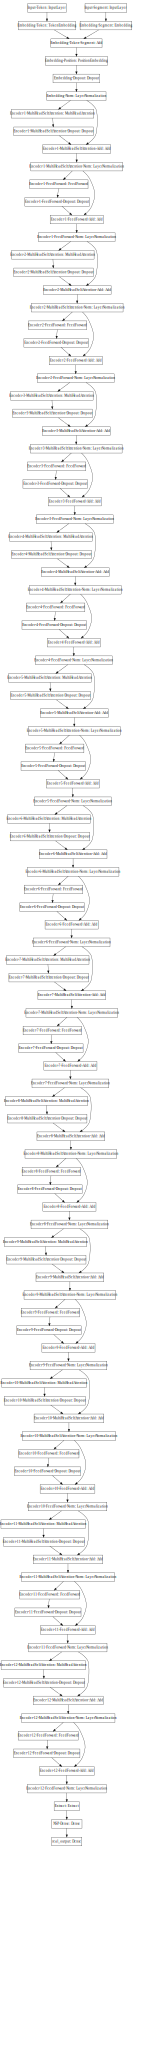

In [0]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


bert_model을 get_bert_finetuning_model 함수로 불러들입니다.
이 다음에 bert_model.fit을 활용하여 버트 모형 파인튜닝을 시작하게 됩니다.


BiLSTM 이나 어텐션 기법을 사용했을 시 보통 테스트셋에 대한 정확도가 86% 정도로 알려져 있습니다.

In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=5, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

Train on 32154 samples, validate on 10718 samples
Epoch 1/5
32154/32154 [==============================] - 665s 21ms/step - loss: 0.4621 - accuracy: 0.7909 - val_loss: 0.3905 - val_accuracy: 0.8252
Epoch 2/5
32154/32154 [==============================] - 650s 20ms/step - loss: 0.3500 - accuracy: 0.8503 - val_loss: 0.3566 - val_accuracy: 0.8475
Epoch 3/5
32154/32154 [==============================] - 650s 20ms/step - loss: 0.2775 - accuracy: 0.8857 - val_loss: 0.3944 - val_accuracy: 0.8447
Epoch 4/5
32154/32154 [==============================] - 650s 20ms/step - loss: 0.1986 - accuracy: 0.9225 - val_loss: 0.3962 - val_accuracy: 0.8446
Epoch 5/5
32154/32154 [==============================] - 650s 20ms/step - loss: 0.1336 - accuracy: 0.9519 - val_loss: 0.4929 - val_accuracy: 0.8456


In [0]:
import matplotlib.pyplot as plt


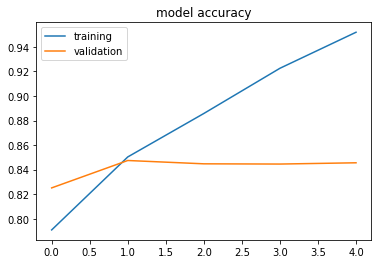

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('model accuracy')
plt.show()

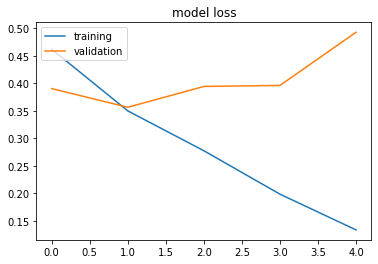

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('model loss')
plt.show()

재사용을 위해 bert_model을 지드라이브에 저장해줍니다.

In [0]:
bert_model.save_weights(path+"/kobert_khaii_preprocessed_final_epoch5_1or0.h5")

버트 모형을 로드해줍니다. 이미 로드하였던 모델에 계수들만 살짝 얹혀 줍니다.

In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/kobert_khaii_preprocessed_final_epoch5_1or0.h5") 

## 모델 평가

파인튜닝한 버트 모형에 test 데이터 셋을 넣어 평가해 봅니다.
사실 머신러닝에서는 정확도인 accuracy도 중요하지만, **F1 score**가 상당히 중요합니다.
  

긍정문장으로 판별된 문장이 진짜로 **긍정 문장에 속할 확률**  
  

부정문장으로 판별된 문장이 진짜로 **부정 문장에 속할 확률**  
 **이 두가지를 고려한 종합적인 성능이 F1 score입니다.**

한번 F1-score를 확인해 보겠습니다.


먼저 테스트 데이터를 버트 모형에 넣을 수 있도록 predict_convert_data 함수를 정의해줍니다. <br> 위에 정의한 convert_data 함수와 다른 점은, test 데이터이기 때문에 label은 고려하지 않는다는 점입니다

In [0]:
vocab = morph_vocab
unk_token = '[UNK]'
SEQ_LEN = 128
max_input_chars_per_word = 128


def predict_convert_data(data_df):
    global tokenizer
    indices, segments= [], []
    for i in tqdm(range(len(data_df))):
        text = khai3.Analyze(data_df[DATA_COLUMN][i])
        text = convert_to_unicode(text)
        text = _clean_text(text)
        orig_tokens = whitespace_tokenize(text)
        
        
        split_tokens = []
        for token in orig_tokens:
          #4. 음절을 정준분해
          #print(token, end=' >> ')
          token = unicodedata.normalize("NFD", token)
          #print(list(token))
          #print('print(token) ==', token, '(사실 출력시에는 변화 X)')
          # https://gist.github.com/Pusnow/aa865fa21f9557fa58d691a8b79f8a6d
          # 모든 음절을 정준 분해(Canonical Decomposition)시킴
          # '각'을 'ㄱ+ㅏ+ㄱ'으로 저장(출력되는 값은 동일)
          output = []
          for char in token:
            cat = unicodedata.category(char)
            if cat == "Mn":
              # unicode category가 "Mark, Nonspacing"일 경우 pass
              continue
            output.append(char)
          token = ''.join(output) # if문에 해당하는 char가 없었기에 원본 text를 출력
                            # 정준분해된 상태임을 기억해라
          #5. punctuation 구분(사실상 의미가 없다)
          chars = list(token)
          i, start_new_word = 0, True
          output = []
          #print(chars)
          #print('char\t_is_puntuation(char)\tstart_new_word\tOutput')
          while i < len(chars):
            char = chars[i]
            #print(char, end='\t')
            #print(_is_punctuation(char), end='\t\t\t')
            if _is_punctuation(char):
              #print('In Here!! <CODE BLOCK "IF _IS_PUNCTUATOIN">')
              output.append([char])
              start_new_word = True
            else:
              if start_new_word:
                output.append([])
              start_new_word = False
              output[-1].append(char)
            #print(start_new_word, end='\t\t')
            #print(output)
            i += 1
          split_tokens.extend(["".join(x) for x in output])
        #print('split_tokens:', split_tokens)
        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        #print('output_tokens:', output_tokens)
        while output_tokens.count('+'):
          output_tokens.remove('+')
        output_tokens = [token + '_' for token in output_tokens]
        SPLIT_TOKENS = []
        for text in output_tokens:
          text = convert_to_unicode(text)
          _output_tokens = []
          # whitespacing 생략
          chars = list(text)
          if len(chars) > max_input_chars_per_word:
            _output_tokens.append(unk_token)
          is_bad = False
          start = 0
          sub_tokens = []
          while start < len(chars):
            end = len(chars)
            cur_substr = None
            while start < end:
              substr = "".join(chars[start:end])
              substr = unicodedata.normalize("NFC", substr)
              if substr in vocab:
                cur_substr = substr
                break
              end -= 1
              #print(substr)
            if cur_substr is None:
              is_bad = True
              break
            sub_tokens.append(cur_substr)
            start = end
          if is_bad:
            _output_tokens.append(unk_token)
          else:
            _output_tokens.extend(sub_tokens)
    
          for sub_token in _output_tokens:
            SPLIT_TOKENS.append(sub_token)
          tokens = ["[CLS]"] + SPLIT_TOKENS + ["[SEP]"]
          if len(tokens) > max_seq_length -2:
            new_msl = max_seq_length -2 
            tokens = tokens[0:new_msl]
            segment_ids = [0] * len(tokens)
            input_ids = [morph_vocab[token] for token in tokens]
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            segment_ids += padding
          else:
            segment_ids = [0] * len(tokens)
            input_ids = [morph_vocab[token] for token in tokens]
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            segment_ids += padding
          
        indices.append(input_ids)
        segments.append(segment_ids)


              
    return [np.vstack(indices), np.vstack(segments)]

def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
     
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x= predict_convert_data(data_df)

    return data_x

In [0]:
test = pd.concat([X_test, y_test], axis=1).reset_index()

In [0]:
test_set = predict_load_data(test)

100%|██████████| 10718/10718 [00:34<00:00, 308.02it/s]


In [0]:
test_set

[array([[    2,   401,  2272, ...,     0,     0,     0],
        [    2, 10013,   205, ...,     0,     0,     0],
        [    2,   427,  6191, ...,     0,     0,     0],
        ...,
        [    2,   965,   140, ...,     0,     0,     0],
        [    2,  3819,  3874, ...,     0,     0,     0],
        [    2,  2393,  1120, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

## 테스트 셋으로 예측하기

In [0]:
#예측
preds = bert_model.predict(test_set)

In [0]:
results = bert_model.evaluate(test_x,test_y)

10718/10718 [==============================] - 53s 5ms/step


In [0]:
print('test accuracy: ',results[1])

test accuracy:  0.8455868363380432


In [0]:
# 부정이면 0, 긍정이면 1 출력
preds

array([[0.99768627],
       [0.272259  ],
       [0.01440987],
       ...,
       [0.9982703 ],
       [0.33873495],
       [0.9915338 ]], dtype=float32)

In [0]:
from sklearn.metrics import classification_report


In [0]:
'''
preds_list = []
for i in range(0, len(preds)):
  preds_list.append([np.where(preds[i] == a) for a in preds[i] if a == max(preds[i])][0][0][0]) 
  '''

'\npreds_list = []\nfor i in range(0, len(preds)):\n  preds_list.append([np.where(preds[i] == a) for a in preds[i] if a == max(preds[i])][0][0][0]) \n  '

In [0]:
y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.75      0.64      0.69      2950
           1       0.87      0.92      0.89      7768

    accuracy                           0.84     10718
   macro avg       0.81      0.78      0.79     10718
weighted avg       0.84      0.84      0.84     10718



F1 스코어와 Accuracy가 거의 비슷함을 알 수 있습니다. 훈련이 치우치지 않고 잘 됐음을 알 수 있습니다.

#### T-SNE
#### 한번 케라스의 장점을 살려 볼까요?
#### 케라스의 장점은 모델을 쉽게 자르고 붙일 수 있다는 점 같습니다
#### 마지막 768개의 피처 부분을 잘라내서, 긍정 영화 평가와 부정 영화 평가의  플롯을 한번 그려보고 상호간 기하학적 관계를 살펴보도록 하겠습니다.

#### 먼저, 마지막 768개 피처를 추출하는 함수를 정의합니다
#### 이번에는 아웃풋이 0과 1 사이의 값이 아닌, 768개의 값을 반환하게 됩니다.

In [0]:

def get_feature_map(model):
  inputs = model.input
  outputs = model.layers[-2].output
  feature_model = Model(inputs, outputs)
  return feature_model

In [0]:
bert_feature = get_feature_map(bert_model)

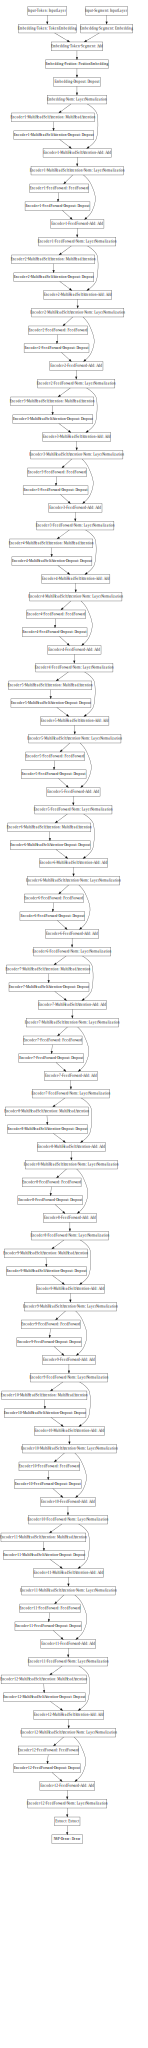

In [0]:
SVG(model_to_dot(bert_feature, dpi=65).create(prog='dot', format='svg'))

마지막 부분을 보시면 768개의 피처가 반환되게 됩니다.

테스트 데이터의 피처들을 반환하고, TSNE 임베딩 플롯을 그려보도록 하겠습니다.

In [0]:
bert_weight_list = bert_feature.predict(test_set)

In [0]:
bert_weight_list

array([[-0.36610508,  0.73061633, -0.2608829 , ..., -0.5184283 ,
        -0.9925559 , -0.6884459 ],
       [-0.24293607, -0.4696387 , -0.2584228 , ..., -0.2042429 ,
         0.88431203,  0.01138197],
       [ 0.17390363, -0.7995483 , -0.05915011, ...,  0.15617889,
         0.95289963,  0.4743766 ],
       ...,
       [-0.5372151 ,  0.5558305 , -0.49546123, ..., -0.60476017,
        -0.9787409 , -0.35602966],
       [-0.07395063, -0.50153637,  0.08331482, ..., -0.07213382,
         0.42698386, -0.19660974],
       [-0.44297203,  0.2246127 , -0.19007653, ..., -0.41124406,
        -0.99097705, -0.40177009]], dtype=float32)

In [0]:
labels = test['label']

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

마지막 768 차원을 PCA를 사용하여 256차원으로 줄여줍니다.
그 다음 TSNE 알고리즘을 활용하여 3차원으로 축소해 줍니다.
TSNE 알고리즘은 유사한 것끼리 클러스터를 만들어 주는 역할을 합니다.

In [0]:
bert_embedded = PCA(n_components=256).fit_transform(bert_weight_list)
bert_embedded = TSNE(n_components=3).fit_transform(bert_embedded)
bert_embedded

array([[ -6.292355 ,   0.6272204,  13.424538 ],
       [  5.215414 ,  -5.1121054,  -7.8281918],
       [  4.505655 ,  -3.0941055, -12.969252 ],
       ...,
       [-14.836985 ,   4.917155 ,   4.6578827],
       [  6.8500376,  -5.01712  ,  -5.8909945],
       [ -1.4357289,   8.057406 ,   2.738661 ]], dtype=float32)

bert 임베딩을 pickle 모듈을 활용하여 저장해 줍니다.  

추후 재사용에 쓸 예정입니다.

In [0]:
with open(path+"/korbertembedding_1or0epoch5_khaii.pkl", "wb") as f:
  pickle.dump(bert_embedded, f)

저장하였던 임베딩 파일을 로드합니다.

In [0]:
with open(path+"/korbertembedding_1or0epoch5_khaii.pkl", "rb") as f:
  bert_embedded = pickle.load(f)

3D로 그리기 위해 matplotlib 모듈들을 로드합니다.

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import seaborn as sns

In [0]:
test

level_0  ... label
0        33781  ...     1
1        26792  ...     1
2        46639  ...     0
3        17702  ...     1
4        10969  ...     1
...        ...  ...   ...
10713     8111  ...     0
10714    40816  ...     0
10715    11505  ...     1
10716     9198  ...     0
10717     8087  ...     1

[10718 rows x 13 columns]

In [0]:

def get_tsne_plot(rot1=-20, rot2=100):
  fig = plt.figure(figsize=(5,5))
  ax = Axes3D(fig)
  colors = 'b', 'r'
  labels = 0, 1
  for i, c, label in zip(range(np.shape(bert_embedded)[0]), colors, labels):
    ax.scatter(bert_embedded[test['label']==label,0], bert_embedded[test['label']==label,1], bert_embedded[test['label']==label,2], s=2, c=c, alpha=0.5)
  ax.view_init(rot1, rot2)
  print("rot1:%d" % rot1, "rot2:%d" % rot2)
  plt.legend(labels, loc='upper right')
  plt.show()

긍정(1)과 부정(0)의 임베딩이 잘 되는지 확인해 봅니다.  

긍정 부분의 클러스터와 부정구간의 클러스터가 잘 구분되는 것을 확인하실 수 있습니다.

In [0]:
import time
for j in range(-180, 180, 45):
  for i in range(-180,180,45):
  
    get_tsne_plot(i, j)

## 한번 문장을 입력하면 긍정인지 부정인지 알려주는 함수를 만들어 볼까요?

In [0]:


def sentence_convert_data(sentence):
    global tokenizer
    indices, segments= [], []
    
    sentence = khai3.Analyze(sentence)
    text = convert_to_unicode(sentence)
    text = _clean_text(text)
    orig_tokens = whitespace_tokenize(text)
        
        
    split_tokens = []
    for token in orig_tokens:
      #4. 음절을 정준분해
      #print(token, end=' >> ')
      token = unicodedata.normalize("NFD", token)
      #print(list(token))
      #print('print(token) ==', token, '(사실 출력시에는 변화 X)')
      # https://gist.github.com/Pusnow/aa865fa21f9557fa58d691a8b79f8a6d
      # 모든 음절을 정준 분해(Canonical Decomposition)시킴
      # '각'을 'ㄱ+ㅏ+ㄱ'으로 저장(출력되는 값은 동일)
      output = []
      for char in token:
        cat = unicodedata.category(char)
        if cat == "Mn":
          # unicode category가 "Mark, Nonspacing"일 경우 pass
          continue
        output.append(char)
      token = ''.join(output) # if문에 해당하는 char가 없었기에 원본 text를 출력
                            # 정준분해된 상태임을 기억해라
      #5. punctuation 구분(사실상 의미가 없다)
      chars = list(token)
      i, start_new_word = 0, True
      output = []
      #print(chars)
      #print('char\t_is_puntuation(char)\tstart_new_word\tOutput')
      while i < len(chars):
        char = chars[i]
        #print(char, end='\t')
        #print(_is_punctuation(char), end='\t\t\t')
        if _is_punctuation(char):
          #print('In Here!! <CODE BLOCK "IF _IS_PUNCTUATOIN">')
          output.append([char])
          start_new_word = True
        else:
          if start_new_word:
            output.append([])
          start_new_word = False
          output[-1].append(char)
        #print(start_new_word, end='\t\t')
        #print(output)
        i += 1
      split_tokens.extend(["".join(x) for x in output])
    #print('split_tokens:', split_tokens)
    output_tokens = whitespace_tokenize(" ".join(split_tokens))
    #print('output_tokens:', output_tokens)
    while output_tokens.count('+'):
      output_tokens.remove('+')
    output_tokens = [token + '_' for token in output_tokens]
    SPLIT_TOKENS = []
    for text in output_tokens:
      text = convert_to_unicode(text)
      _output_tokens = []
      # whitespacing 생략
      chars = list(text)
      if len(chars) > max_input_chars_per_word:
        _output_tokens.append(unk_token)
      is_bad = False
      start = 0
      sub_tokens = []
      while start < len(chars):
        end = len(chars)
        cur_substr = None
        while start < end:
          substr = "".join(chars[start:end])
          substr = unicodedata.normalize("NFC", substr)
          if substr in vocab:
            cur_substr = substr
            break
          end -= 1
          #print(substr)
        if cur_substr is None:
          is_bad = True
          break
        sub_tokens.append(cur_substr)
        start = end
      if is_bad:
        _output_tokens.append(unk_token)
      else:
        _output_tokens.extend(sub_tokens)
    
      for sub_token in _output_tokens:
        SPLIT_TOKENS.append(sub_token)
      tokens = ["[CLS]"] + SPLIT_TOKENS + ["[SEP]"]
      if len(tokens) > max_seq_length -2:
        new_msl = max_seq_length -2 
        tokens = tokens[0:new_msl]
        segment_ids = [0] * len(tokens)
        input_ids = [morph_vocab[token] for token in tokens]
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        segment_ids += padding
      else:
        segment_ids = [0] * len(tokens)
        input_ids = [morph_vocab[token] for token in tokens]
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        segment_ids += padding
          
    indices.append(input_ids)
    segments.append(segment_ids)


              
    return [np.vstack(indices), np.vstack(segments)]

def cosmetic_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = bert_model.predict(data_x)
    predict_answer = np.round(np.ravel(predict), 0).item()
    
    if predict_answer == 0:
      print("부정적인 리뷰입니다.")
    elif predict_answer == 1:
      print("긍정적인 리뷰입니다.")

In [0]:
cosmetic_evaluation_predict("부드럽게 발려서 좋았어요")

긍정적인 리뷰입니다.


In [0]:
cosmetic_evaluation_predict("분사력이 별로에요")

부정적인 리뷰입니다.


In [0]:
cosmetic_evaluation_predict("홈쇼핑에서다량으로산걸후회중인울마미ㅜㅜ") 

부정적인 리뷰입니다.


In [0]:
cosmetic_evaluation_predict("향이 무엇보다 너무 맘에 안들어서 안쓰게 되던")

부정적인 리뷰입니다.


In [0]:
cosmetic_evaluation_predict("한통 깔끔히 다쓰고 재구매하면서 주변 사람들한테 추천하는중")

긍정적인 리뷰입니다.
